In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from astral.geocoder import database, lookup
from astral.sun import daylight

# Load the data

In [2]:
base_path = "."
destination_data_h5_path = os.path.join(base_path, "..", "datasets", "SolarEnergyProduction.h5")
source_data = os.path.join(base_path, "data", "SolarEnergyProduction", "Solar_Energy_Production.csv")

In [3]:
df = pd.read_csv(source_data)
print(df.shape)
df['date'] = pd.to_datetime(df['date'])
df.head()

(258423, 8)


KeyboardInterrupt: 

# Add number of daylight hours

In [4]:
astral_db = database()
calgary_info = lookup("Calgary", astral_db)

def daylight_hours(row, feature_name='date'):
    time_sunrise, time_sunset = daylight(calgary_info.observer, row[feature_name], tzinfo=calgary_info.timezone)
    return (time_sunset - time_sunrise).total_seconds() / 3600

# Group by day

In [5]:
df['day'] = df['date'].dt.to_period('D')

daily = df.groupby(['id', 'day'])['kWh'].sum().to_frame().reset_index()
daily['date'] = daily['day'].dt.to_timestamp()
daily.drop(columns=['day'], inplace=True)

# daily = daily.resample('D').first()
# daily.ffill(inplace=True)

In [6]:
# Fill in missing values
daily_without_nans = pd.DataFrame()
for i in daily['id'].unique():
    daily_i = daily.loc[daily['id'] == i]
    daily_i.set_index('date', inplace=True)
    daily_i = daily_i.resample('D').first()
    daily_i.ffill(inplace=True)
    daily_i.reset_index(inplace=True)
    daily_without_nans = pd.concat([daily_without_nans, daily_i])
    
daily_without_nans.head()

,date,id,kWh
0,2015-09-01,164440.0,286.013
1,2015-09-02,164440.0,681.646
2,2015-09-03,164440.0,647.906
3,2015-09-04,164440.0,102.448
4,2015-09-05,164440.0,93.432


In [7]:
daily = daily_without_nans

In [8]:
daily['daylight_hours'] = daily.apply(lambda x: daylight_hours(x, 'date'), axis=1)
print(daily.shape)
daily.head()

(22376, 4)


,date,id,kWh,daylight_hours
0,2015-09-01,164440.0,286.013,13.533085
1,2015-09-02,164440.0,681.646,13.470491
2,2015-09-03,164440.0,647.906,13.407756
3,2015-09-04,164440.0,102.448,13.344890
4,2015-09-05,164440.0,93.432,13.281901


# Group by month

In [9]:
monthly = daily.groupby(['id', daily['date'].dt.to_period('M')])[['kWh', 'daylight_hours']].sum().reset_index()
monthly['date'] = monthly['date'].dt.to_timestamp()

daily.set_index(['id', 'date'], inplace=True)
monthly.set_index(['id', 'date'], inplace=True)
print(monthly.shape)
monthly.head()

(746, 2)


kWh  daylight_hours
id       date                                 
164440.0 2015-09-01  16375.758      378.387037
         2015-10-01  15068.149      330.919331
         2015-11-01   4302.924      267.965801
         2015-12-01   1722.972      247.696505
         2016-01-01   3081.863      263.193197

In [10]:
print(daily.shape)
daily.head()

(22376, 2)


kWh  daylight_hours
id       date                               
164440.0 2015-09-01  286.013       13.533085
         2015-09-02  681.646       13.470491
         2015-09-03  647.906       13.407756
         2015-09-04  102.448       13.344890
         2015-09-05   93.432       13.281901

# Save the data

In [11]:
daily.to_hdf(destination_data_h5_path, key='daily', mode='w')
monthly.to_hdf(destination_data_h5_path, key='monthly', mode='a')

# Plot the data

In [12]:
id_to_plot = 164440
daily_kwh = daily[['kWh']].loc[id_to_plot].squeeze()
daily_kwh_normalized = daily_kwh/daily[['daylight_hours']].loc[id_to_plot].squeeze()

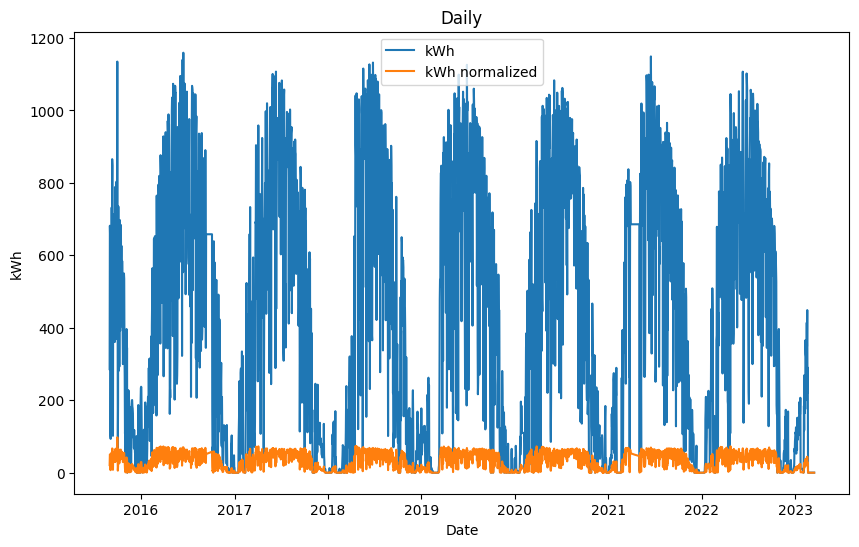

In [13]:
plt.figure(figsize=(10,6))
plt.plot(daily_kwh, label='kWh')
plt.plot(daily_kwh_normalized, label='kWh normalized')
plt.title('Daily')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()

In [14]:
monthly_kwh = monthly[['kWh']].loc[id_to_plot].squeeze()
monthly_kwh_normalized = monthly_kwh/monthly[['daylight_hours']].loc[id_to_plot].squeeze()

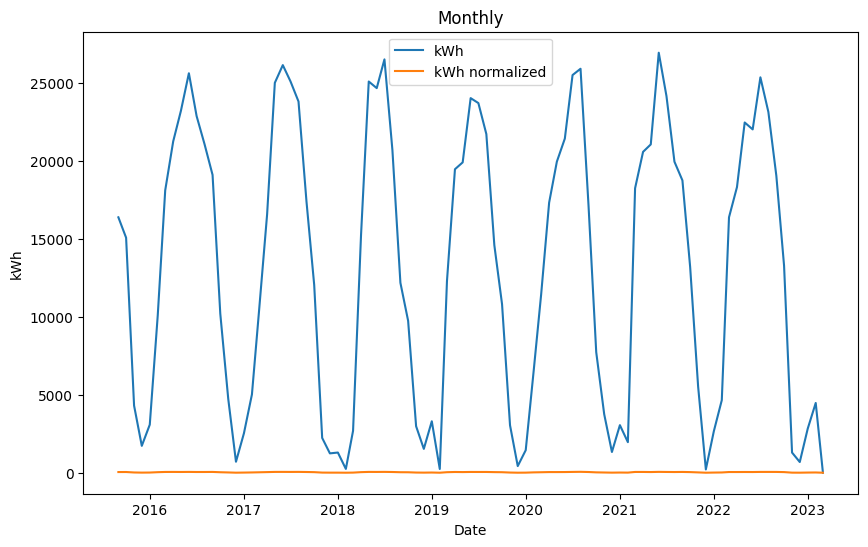

In [15]:
plt.figure(figsize=(10,6))
plt.plot(monthly_kwh, label='kWh')
plt.plot(monthly_kwh_normalized, label='kWh normalized')
plt.title('Monthly')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()

# Some checks

In [16]:
# Check if all instances have the same dates  --> No
daily_dates = daily.reset_index()
first_encountered_dates = None
for i in daily_dates['id'].unique():
    dates: np.ndarray = daily_dates[daily_dates['id'] == i]['date'].values
    if first_encountered_dates is None:
        first_encountered_dates = dates
    else:
        if not (first_encountered_dates.shape == dates.shape and
                first_encountered_dates == dates.all()):
            print(f"Dates for id {i} are not the same")


Dates for id 308057.0 are not the same
Dates for id 314106.0 are not the same
Dates for id 319086.0 are not the same
Dates for id 331901.0 are not the same
Dates for id 332785.0 are not the same
Dates for id 355827.0 are not the same
Dates for id 551172.0 are not the same
Dates for id 570079.0 are not the same
Dates for id 577650.0 are not the same
Dates for id 594148.0 are not the same


In [17]:
# Find the id with the largest number of days
counts = daily.groupby('id').count()
max_id = counts[counts['kWh'] == counts['kWh'].max()].index[0]
print(f"ID with the largest number of days: {max_id}")
print(f"Number of days: {counts.loc[max_id]['kWh']}")
print(counts)

ID with the largest number of days: 164440.0
Number of days: 2754
           kWh  daylight_hours
id                            
164440.0  2754            2754
308057.0  2355            2355
314106.0  2304            2304
319086.0  2223            2223
331901.0  2275            2275
332785.0  2289            2289
355827.0  2196            2196
551172.0  2003            2003
570079.0  1989            1989
577650.0  1942            1942
594148.0    46              46


In [18]:
from sklearn.model_selection import TimeSeriesSplit
splitter = TimeSeriesSplit(n_splits=5)
max_instance = daily.loc[max_id]
generator = splitter.split(max_instance)

train_indices_all_folds = []
test_indices_all_folds = []
max_dates = []
min_dates = []

# Use the same split for all instances, but look at the exact dates, not just the n first time steps
for (train_index, test_index) in generator:
    train_dates = max_instance.iloc[train_index].index
    test_dates = max_instance.iloc[test_index].index
    max_train_date = max(train_dates)
    max_dates.append(max_train_date)
    # min_test_date = min(test_dates)
    # min_dates.append(min_test_date)
    # offset = 0
    all_train_indices = np.empty(0, dtype=int)
    all_test_indices = np.empty(0, dtype=int)
    for i in daily_dates['id'].unique():
        train_indices = daily_dates[daily_dates['id'] == i].index[daily_dates[daily_dates['id'] == i]['date'] <= max_train_date]
        test_indices = daily_dates[daily_dates['id'] == i].index[daily_dates[daily_dates['id'] == i]['date'] > max_train_date]
        all_train_indices = np.concatenate((all_train_indices, train_indices))
        all_test_indices = np.concatenate((all_test_indices, test_indices))
        # assert daily_dates[daily_dates['id'] == i].shape[0] == train_indices.shape[0] + test_indices.shape[0]
        # offset += daily_dates[daily_dates['id'] == i].shape[0]
        # print(f"ID: {i}")
        # print(f"Train: {train_indices}")
        # print(f"Test: {test_indices}")
        # print()
    train_indices_all_folds.append(all_train_indices)
    test_indices_all_folds.append(all_test_indices)
        

In [19]:
# Check if the splits are correct
for fold in range(len(train_indices_all_folds)):
    Itrain = train_indices_all_folds[fold]
    Itest = test_indices_all_folds[fold]
    max_train_date = max_dates[fold]
    # min_test_date = min_dates[fold]
    train_dates = daily_dates.iloc[Itrain]['date']
    test_dates = daily_dates.iloc[Itest]['date']
    assert all(train_dates <= max_train_date)
    assert all(test_dates > max_train_date)


# Trends

In [20]:
daily_kwh = daily_kwh.to_frame()

In [21]:
daily_kwh = daily_kwh.resample('D').first()

In [22]:
daily_kwh.ffill(inplace=True)

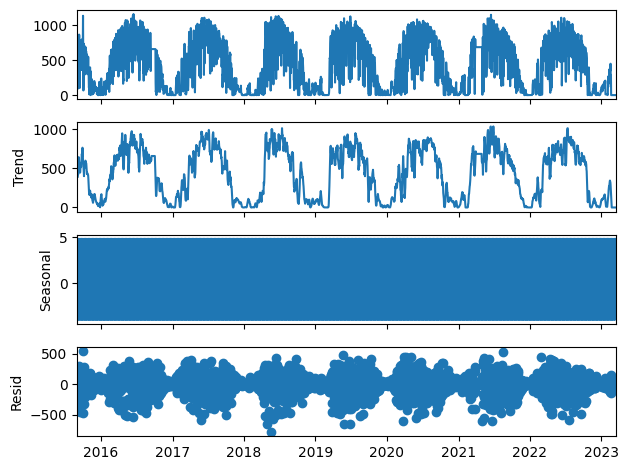

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(daily_kwh, model='additive')
decomposition.plot()
plt.show()

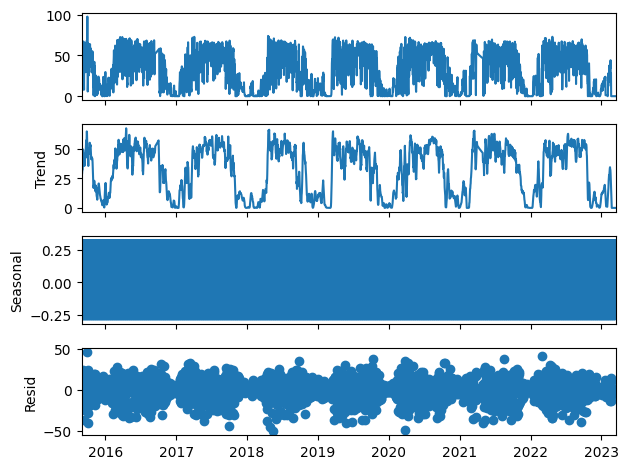

In [34]:
decomposition = seasonal_decompose(daily_kwh_normalized, model='additive')
decomposition.plot()
plt.show()

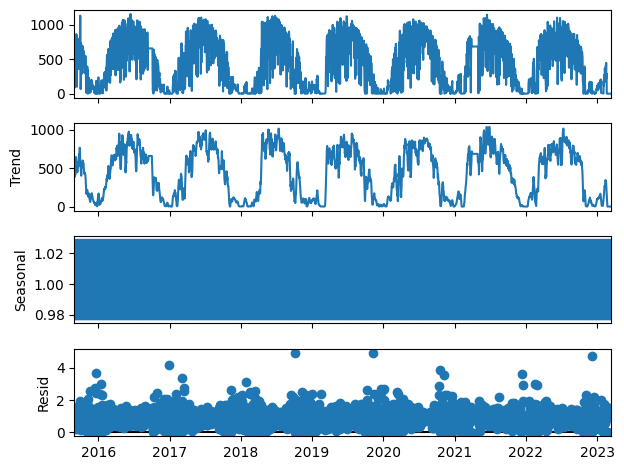

In [24]:
daily_kwh_offset = daily_kwh + 1
decomposition = seasonal_decompose(daily_kwh_offset, model='multiplicative')
decomposition.plot()
plt.show()

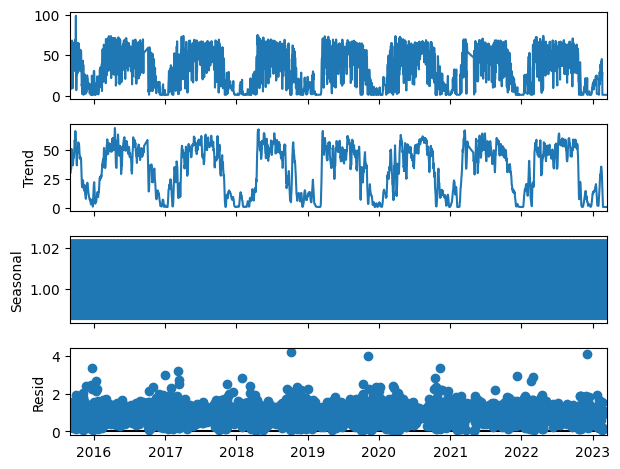

In [36]:
decomposition = seasonal_decompose(daily_kwh_normalized + 1, model='multiplicative')
decomposition.plot()
plt.show()

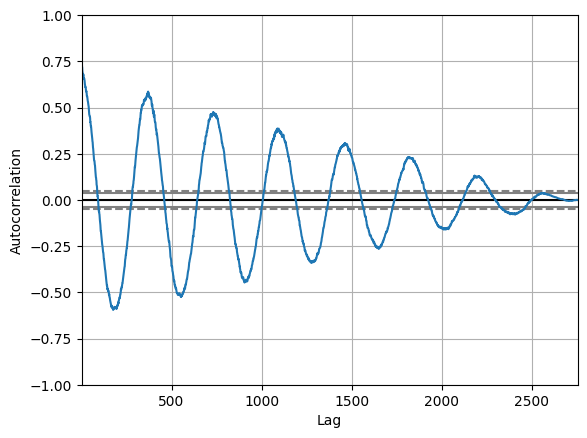

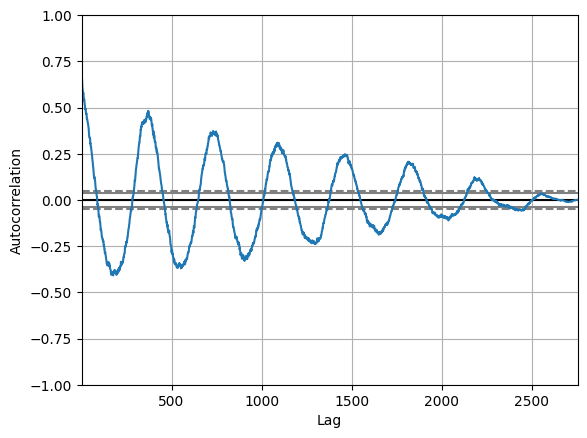

In [38]:
import pmdarima as pm
pm.utils.autocorr_plot(daily_kwh)
pm.utils.autocorr_plot(daily_kwh_normalized)

# Stationarity

If p-value is greater than 0.05, the data is non-stationary, and we need to difference it.

## Daily

In [26]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity with ADF test
result = adfuller(daily_kwh['kWh'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.4834919393124575
p-value: 0.00842131661227901


Daily unnormalized is stationary.

In [32]:
result = adfuller(daily_kwh_normalized)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -4.502059138641061
p-value: 0.00019496210132227047


Daily normalized is stationary.

## Monthly

In [31]:
result = adfuller(monthly_kwh)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.238475446468888
p-value: 0.19257851270573556


Monthly unnormalized is not stationary.

In [33]:
result = adfuller(monthly_kwh_normalized)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.233684334113423
p-value: 0.19424786043646425


Monthly normalized is not stationary.